<a href="https://colab.research.google.com/github/nobrainkid/CNN/blob/main/Resnet_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
import keras
from keras.datasets import cifar10
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy.misc
import matplotlib.pyplot as plt

import keras.backend as K
K.set_image_data_format('channels_last')

In [39]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [40]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1, 1), name = conv_name_base + '2b', padding='same')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), name=conv_name_base + '2c', padding='valid')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), name=conv_name_base + '1', padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut) 

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [41]:
def ResNet(input_shape, classes):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (8, 8), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')
    X = MaxPooling2D((4, 4), strides=(2, 2), padding="same")(X)

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [16, 16, 256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [16, 16, 256], stage=3, block='b')
    X = identity_block(X, 3, [16, 16, 256], stage=3, block='c')
    X = identity_block(X, 3, [16, 16, 256], stage=3, block='d')
    X = identity_block(X, 3, [16, 16, 256], stage=3, block='e')
    X = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(X)

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [8, 8, 512], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [8, 8, 512], stage=5, block='b')
    X = identity_block(X, 3, [8, 8, 512], stage=5, block='c')
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet')

    return model

In [42]:
def load_dataset():
  (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

  # Normalize image vectors
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  X_train = X_train/255.
  X_test = X_test/255.

  Y_train = keras.utils.to_categorical(Y_train, 10)
  Y_test = keras.utils.to_categorical(Y_test, 10)

  # print ("number of training examples = " + str(X_train.shape[0]))
  # print ("number of test examples = " + str(X_test.shape[0]))
  # print ("X_train shape: " + str(X_train.shape))
  # print ("Y_train shape: " + str(Y_train.shape))
  # print ("X_test shape: " + str(X_test.shape))
  # print ("Y_test shape: " + str(Y_test.shape))

  return X_train, Y_train, X_test, Y_test

Epoch 1/150
2500/2500 [==============================] - 151s 59ms/step - loss: 2.2942 - accuracy: 0.2277 - val_loss: 1.7979 - val_accuracy: 0.3902
Epoch 2/150
2500/2500 [==============================] - 148s 59ms/step - loss: 1.8309 - accuracy: 0.3494 - val_loss: 1.7921 - val_accuracy: 0.4028
Epoch 3/150
2500/2500 [==============================] - 151s 60ms/step - loss: 1.6725 - accuracy: 0.4026 - val_loss: 1.5050 - val_accuracy: 0.4772
Epoch 4/150
2500/2500 [==============================] - 153s 61ms/step - loss: 1.5930 - accuracy: 0.4327 - val_loss: 1.5722 - val_accuracy: 0.4348
Epoch 5/150
2500/2500 [==============================] - 156s 62ms/step - loss: 1.5249 - accuracy: 0.4568 - val_loss: 1.5704 - val_accuracy: 0.4680
Epoch 6/150
2500/2500 [==============================] - 155s 62ms/step - loss: 1.4740 - accuracy: 0.4772 - val_loss: 1.8642 - val_accuracy: 0.3580
Epoch 7/150
2500/2500 [==============================] - 160s 64ms/step - loss: 1.4146 - accuracy: 0.4992 - val_

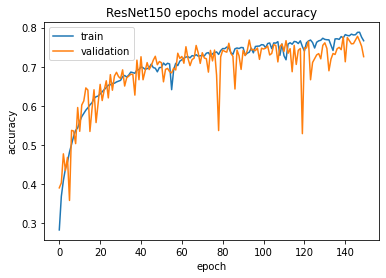

<Figure size 432x288 with 0 Axes>

In [43]:
X_train, Y_train, X_test, Y_test = load_dataset()

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
num_epochs = 150

model = ResNet(input_shape = (32, 32, 3), classes = 10)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Generate extra data
datagen = ImageDataGenerator(width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=0.3,
                        fill_mode='nearest',
                        horizontal_flip = True)

datagen.fit(X_train)


history = model.fit(datagen.flow(X_train, Y_train, batch_size=16), epochs=num_epochs, validation_data=(X_val, Y_val))

model.save(str(num_epochs) + '_epochs_model')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet' + str(num_epochs) + ' epochs model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.savefig(str(num_epochs) + '_epochs_model.png')

In [44]:
# kf = KFold(n_splits = 5, random_state = 5, shuffle = True) 
# X_train, Y_train, X_test, Y_test = load_dataset()
# start_epochs = 20
# i = 1

# for train_index, val_index in kf.split(X_train):
#   training_data = X_train[train_index]
#   training_labels = Y_train[train_index]
#   validation_data = X_train[val_index]
#   validation_labels = Y_train[val_index]
#   num_epochs = start_epochs * i

#   model = ResNet(input_shape = (32, 32, 3), classes = 10)
#   model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

#   # Generate extra data
#   datagen = ImageDataGenerator(width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.3,
#                          fill_mode='nearest',
#                          horizontal_flip = True)
  
#   datagen.fit(training_data)


#   history = model.fit(datagen.flow(training_data, training_labels), epochs=num_epochs, validation_data=(validation_data, validation_labels))

#   model.save(str(num_epochs) + '_epochs_model')

#   plt.plot(history.history['accuracy'])
#   plt.plot(history.history['val_accuracy'])
#   plt.title(str(num_epochs) + ' epochs model accuracy')
#   plt.ylabel('accuracy')
#   plt.xlabel('epoch')
#   plt.legend(['train', 'validation'], loc='upper left')
#   plt.show()

#   plt.savefig(str(num_epochs) + '_epochs_model.png')
#   i +=1

In [45]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 72.36%
